In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy import stats

In [2]:
np.random.seed(200)

In [3]:
def gaussmf(x, mean, sigma):

    return np.exp(-((x - mean)**2.) / (2 * sigma**2.))

In [4]:
#T function
def T(x,L1,L2,cn):
    r = x - np.dot(L1,x) + L2
    s = np.abs(r)-cn
    s = np.maximum(s,0,s)
    return s*np.sign(r)

def thetan(x0,x1,n):
    if (x0==x1).all():
        return 0
    else:
        return 1/(2**n*np.linalg.norm(x1-x0,'fro'))

In [5]:
df = pd.read_csv('transfusion.csv')

In [6]:
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [7]:
df_x = df.drop(['whether he/she donated blood in March 2007'], axis=1)

In [8]:
Dict = {}
for k in df_x.keys():
    t = df[k]
    
    x = np.array(t.to_list()).reshape(-1, 1)
    kmeans = KMeans(n_clusters=3, random_state=0).fit(x)
    label = kmeans.labels_
    
    x_0 = [i[-1] for i, j in zip(x,label) if j==0]
    x_1 = [i[-1] for i, j in zip(x,label) if j==1]
    x_2 = [i[-1] for i, j in zip(x,label) if j==2]
    
    std_x_0 = np.std(x_0)
    std_x_1 = np.std(x_1)
    std_x_2 = np.std(x_2)
    
    center = kmeans.cluster_centers_
    
    mean_0 = center[0][0]
    mean_1 = center[1][0]
    mean_2 = center[2][0]
    
    type_0 = gaussmf(t, mean_0, std_x_0)
    type_1 = gaussmf(t, mean_1, std_x_1)
    type_2 = gaussmf(t, mean_2, std_x_2)

    Dict[k+'_t0'] = type_0
    Dict[k+'_t1'] = type_1
    Dict[k+'_t2'] = type_2

In [9]:
X = pd.DataFrame(Dict)

In [10]:
X.head(10)

,Recency (months)_t0,Recency (months)_t1,Recency (months)_t2,Frequency (times)_t0,Frequency (times)_t1,Frequency (times)_t2,Monetary (c.c. blood)_t0,Monetary (c.c. blood)_t1,Monetary (c.c. blood)_t2,Time (months)_t0,Time (months)_t1,Time (months)_t2
1,0.082978,8.255531e-08,1.969166e-68,2.851039e-04,0.937543,8.344870e-23,2.851039e-04,0.937543,8.344870e-23,8.726445e-04,1.190911e-01,0.553261
2,0.317026,9.140942e-07,2.014046e-62,1.697007e-08,0.808705,1.089867e-36,1.697007e-08,0.808705,1.089867e-36,6.768440e-03,1.043910e-02,0.964047
3,0.725970,8.356140e-06,1.082914e-56,1.120636e-16,0.135506,1.918200e-60,1.120636e-16,0.135506,1.918200e-60,6.869178e-02,6.566681e-05,0.668684
5,0.819688,3.929540e-04,4.548365e-46,2.036595e-01,0.003179,2.253215e-01,2.036595e-01,0.003179,2.253215e-01,5.407129e-08,4.747297e-01,0.000516
6,0.725970,8.356140e-06,1.082914e-56,9.876743e-01,0.058781,3.794322e-05,9.876743e-01,0.058781,3.794322e-05,5.059193e-06,9.891800e-01,0.024547
7,0.317026,9.140942e-07,2.014046e-62,3.159826e-03,0.784851,6.317105e-19,3.159826e-03,0.784851,6.317105e-19,6.768440e-03,1.043910e-02,0.964047
8,0.725970,8.356140e-06,1.082914e-56,3.485807e-01,0.233004,1.552612e-09,3.485807e-01,0.233004,1.552612e-09,1.140024e-04,4.623962e-01,0.201949
10,0.819688,3.929540e-04,4.548365e-46,1.010314e-24,0.010775,3.429421e-82,1.010314e-24,0.010775,3.429421e-82,4.786437e-01,5.498866e-09,0.054111
11,0.082978,8.255531e-08,1.969166e-68,5.206611e-02,0.000958,7.274033e-01,5.206611e-02,0.000958,7.274033e-01,5.407129e-08,4.747297e-01,0.000516
12,0.725970,8.356140e-06,1.082914e-56,1.104875e-01,0.391267,2.724833e-12,1.104875e-01,0.391267,2.724833e-12,8.726445e-04,1.190911e-01,0.553261


In [11]:
y = pd.get_dummies(df['whether he/she donated blood in March 2007'])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [13]:
H = X_train
itrs = 500
L = 1. / np.max(np.linalg.eigvals(np.dot(H.T, H))).real
m = H.shape[1]
n = y_train.shape[1]
x0 = np.zeros((m,n))
x1 = np.zeros((m,n))
L1 = 2*L*np.dot(H.T, H)
L2 = 2*L*np.dot(H.T, y_train)
lam=1e-2
acc_rate_validation = []
acc_rate_train = []
for i in range(1,itrs+1):
    cn = ((2e-6*i)/(2*i+1))*lam*L
    beta = 0.9*i/(i+1)
    alpha = 0.9*i/(i+1)

    y = x1 + thetan(x0,x1,i)*(x1-x0)
    z = (1-beta)*x1 + beta*T(x1,L1,L2,cn)

    Ty = T(y,L1,L2,cn)
    Tz = T(z,L1,L2,cn)
    x = (1-alpha)*Ty + alpha*Tz

    x0, x1 = x1, x
    
    W = x

    predict_val = X_test.dot(W).values

    actual_val  = y_test.values

    acc_rate_validation.append([i, np.sum(np.argmax(predict_val, axis=1) == np.argmax(actual_val, axis=1)) / y_test.shape[0]])
    
    predict_train = X_train.dot(W).values

    actual_train  = y_train.values

    acc_rate_train.append([i, np.sum(np.argmax(predict_train, axis=1) == np.argmax(actual_train, axis=1)) / y_train.shape[0]])

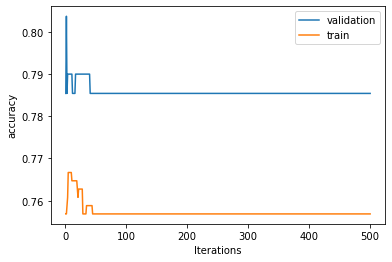

In [14]:
plt.xlabel('Iterations')
plt.ylabel('accuracy')
plt.plot(range(1,itrs+1), [x[1] for x in acc_rate_validation], label='validation')
plt.plot(range(1,itrs+1), [x[1] for x in acc_rate_train], label='train')
plt.legend()